In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

train_df = pd.read_csv("data\encoded_loan_data_train.csv")
test_df = pd.read_csv("data\encoded_loan_data_test.csv")

target_col = "Default"

if "LoanID" in train_df.columns:
    train_df = train_df.drop(columns=["LoanID"])
if "LoanID" in test_df.columns:
    test_df = test_df.drop(columns=["LoanID"])

if target_col in test_df.columns:
    test_df = test_df.drop(columns=[target_col])

feature_cols = [col for col in train_df.columns if col != target_col]

X = train_df[feature_cols]
y = train_df[target_col]

mask = ~y.isna()
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.20
)

train_data = pd.concat([X_train, y_train], axis=1)

majority = train_data[train_data[target_col] == 0]
minority = train_data[train_data[target_col] == 1]

# Undersample majority
n_majority_target = math.floor(len(minority) * 2)
majority_downsampled = majority.sample(n=n_majority_target, random_state=43)

train_balanced = pd.concat([majority_downsampled, minority]).sample(frac=1, random_state=42)

X_train_balanced = train_balanced[feature_cols]
y_train_balanced = train_balanced[target_col]

print("Balanced class counts:")
print(train_balanced[target_col].value_counts())

Balanced class counts:
Default
0    45554
1    22777
Name: count, dtype: int64


Accuracy: 0.8370287344609741


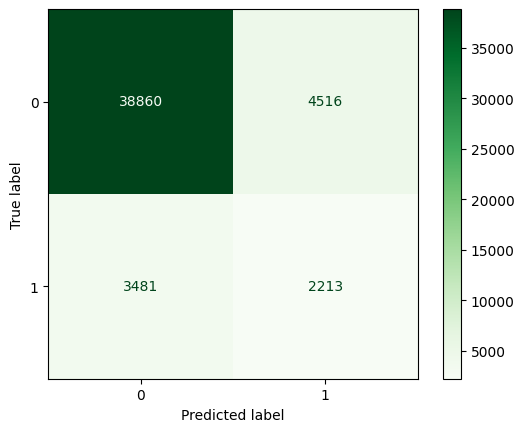


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     43376
           1       0.33      0.39      0.36      5694

    accuracy                           0.84     49070
   macro avg       0.62      0.64      0.63     49070
weighted avg       0.85      0.84      0.84     49070


Random Forest Feature Importance:
                         Feature  Importance
0                            Age    0.131295
6                   InterestRate    0.130603
1                         Income    0.123469
2                     LoanAmount    0.107255
4                 MonthsEmployed    0.098143
3                    CreditScore    0.086576
8                       DTIRatio    0.077402
7                       LoanTerm    0.034464
9                      Education    0.029439
5                 NumCreditLines    0.028899
10                   HasMortgage    0.013631
11                 HasDependents    0.012409
12                   HasCoSig

In [4]:
rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=30,
        min_samples_leaf=2,
        random_state=42
    ))
])

# Train
rf_pipeline.fit(X_train_balanced, y_train_balanced)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Greens")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

importances = rf_pipeline.named_steps["rf"].feature_importances_
feature_importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nRandom Forest Feature Importance:")
print(feature_importance)



Best parameters: {'rf__max_depth': 30, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 300}
Best CV F1 score: 0.4794494588067023

Test Accuracy (Tuned): 0.8370287344609741


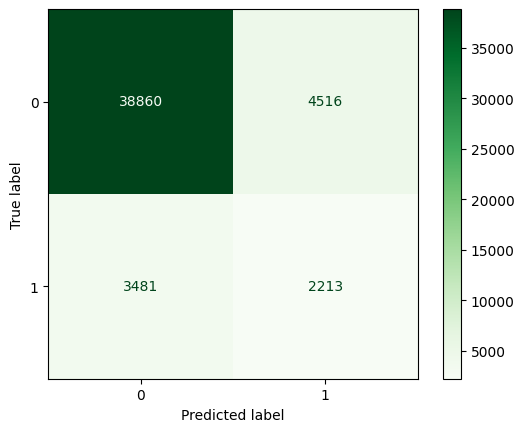


Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     43376
           1       0.33      0.39      0.36      5694

    accuracy                           0.84     49070
   macro avg       0.62      0.64      0.63     49070
weighted avg       0.85      0.84      0.84     49070



In [ ]:

param_grid_rf = {
    "rf__n_estimators": [200, 250,  300],
    "rf__max_depth": [None, 20, 30, 40, 50],
    "rf__min_samples_leaf": [1, 2, 3, 4]
}

grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid_rf,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_search_rf.fit(X_train_balanced, y_train_balanced)

print("\nBest parameters:", grid_search_rf.best_params_)
print("Best CV F1 score:", grid_search_rf.best_score_)

y_pred_rf_best = grid_search_rf.best_estimator_.predict(X_test)

print("\nTest Accuracy (Tuned):", accuracy_score(y_test, y_pred_rf_best))

cm = confusion_matrix(y_test, y_pred_rf_best, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Greens")
plt.show()

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_rf_best))
